# Capstone 2 - Nuclear feature extraction for breast tumor diagnosis

In [1]:
# Import necessary
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import sklearn
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

In [2]:
# Header
cols = ['ID','Diagnosis','radius','texture','perimeter','area','smoothness','compactness','concavity',
        'concave_points','symmetry','fractal_dimension','radius_stde','texture_stde','perimeter_stde','area_stde',
        'smoothness_stde','compactness_stde','concavity_stde','concave_points_stde','symmetry_stde',
        'fractal_dimension_stde','radius_ext','texture_ext','perimeter_ext','area_ext',
        'smoothness_ext','compactness_ext','concavity_ext','concave_points_ext','symmetry_ext','fractal_dimension_ext']

In [3]:
# Data - target feature is Diagnosis
df = pd.read_table('wdbc.data',sep=',',names = cols)
df.info
df.head()

,ID,Diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,...,radius_ext,texture_ext,perimeter_ext,area_ext,smoothness_ext,compactness_ext,concavity_ext,concave_points_ext,symmetry_ext,fractal_dimension_ext
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# No duplicate IDs
df['ID'].value_counts(ascending = False).head()

842302     1
90250      1
901315     1
9013579    1
9013594    1
Name: ID, dtype: int64

In [5]:
df.isnull().sum()
# No null values, but source specified that null values in this dataset were labeled 0
pd.set_option('display.max_columns', None)
df[df.eq(0).any(axis=1)]

,ID,Diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,symmetry,fractal_dimension,radius_stde,texture_stde,perimeter_stde,area_stde,smoothness_stde,compactness_stde,concavity_stde,concave_points_stde,symmetry_stde,fractal_dimension_stde,radius_ext,texture_ext,perimeter_ext,area_ext,smoothness_ext,compactness_ext,concavity_ext,concave_points_ext,symmetry_ext,fractal_dimension_ext
101,862722,B,6.981,13.43,43.79,143.5,0.11700,0.07568,0.0,0.0,0.1930,0.07818,0.2241,1.5080,1.553,9.833,0.010190,0.010840,0.0,0.0,0.02659,0.004100,7.930,19.54,50.41,185.2,0.15840,0.12020,0.0,0.0,0.2932,0.09382
140,868999,B,9.738,11.97,61.24,288.5,0.09250,0.04102,0.0,0.0,0.1903,0.06422,0.1988,0.4960,1.218,12.260,0.006040,0.005656,0.0,0.0,0.02277,0.003220,10.620,14.10,66.53,342.9,0.12340,0.07204,0.0,0.0,0.3105,0.08151
174,871642,B,10.660,15.15,67.49,349.6,0.08792,0.04302,0.0,0.0,0.1928,0.05975,0.3309,1.9250,2.155,21.980,0.008713,0.010170,0.0,0.0,0.03265,0.001002,11.540,19.20,73.20,408.3,0.10760,0.06791,0.0,0.0,0.2710,0.06164
175,872113,B,8.671,14.45,54.42,227.2,0.09138,0.04276,0.0,0.0,0.1722,0.06724,0.2204,0.7873,1.435,11.360,0.009172,0.008007,0.0,0.0,0.02711,0.003399,9.262,17.04,58.36,259.2,0.11620,0.07057,0.0,0.0,0.2592,0.07848
192,875099,B,9.720,18.22,60.73,288.1,0.06950,0.02344,0.0,0.0,0.1653,0.06447,0.3539,4.8850,2.230,21.690,0.001713,0.006736,0.0,0.0,0.03799,0.001688,9.968,20.83,62.25,303.8,0.07117,0.02729,0.0,0.0,0.1909,0.06559
314,894047,B,8.597,18.60,54.09,221.2,0.10740,0.05847,0.0,0.0,0.2163,0.07359,0.3368,2.7770,2.222,17.810,0.020750,0.014030,0.0,0.0,0.06146,0.006820,8.952,22.44,56.65,240.1,0.13470,0.07767,0.0,0.0,0.3142,0.08116
391,903483,B,8.734,16.84,55.27,234.3,0.10390,0.07428,0.0,0.0,0.1985,0.07098,0.5169,2.0790,3.167,28.850,0.015820,0.019660,0.0,0.0,0.01865,0.006736,10.170,22.80,64.01,317.0,0.14600,0.13100,0.0,0.0,0.2445,0.08865
473,9113846,B,12.270,29.97,77.42,465.4,0.07699,0.03398,0.0,0.0,0.1701,0.05960,0.4455,3.6470,2.884,35.130,0.007339,0.008243,0.0,0.0,0.03141,0.003136,13.450,38.05,85.08,558.9,0.09422,0.05213,0.0,0.0,0.2409,0.06743
538,921092,B,7.729,25.49,47.98,178.8,0.08098,0.04878,0.0,0.0,0.1870,0.07285,0.3777,1.4620,2.492,19.140,0.012660,0.009692,0.0,0.0,0.02882,0.006872,9.077,30.92,57.17,248.0,0.12560,0.08340,0.0,0.0,0.3058,0.09938
550,923748,B,10.860,21.48,68.51,360.5,0.07431,0.04227,0.0,0.0,0.1661,0.05948,0.3163,1.3040,2.115,20.670,0.009579,0.011040,0.0,0.0,0.03004,0.002228,11.660,24.77,74.08,412.3,0.10010,0.07348,0.0,0.0,0.2458,0.06592


In [6]:
missing_data_idlist = list(df[df.eq(0).any(axis=1)].index)

df.drop(index=missing_data_idlist,inplace=True)

In [ ]:
# DNR
areas_only = pd.DataFrame([df.area1,df.area2,df.area3])
areas_t = areas_only.T
areas_t.index = df.ID
areas_t
# Determined: 1,2,3 = mean, stderror, extreme

In [7]:
df.Diagnosis.value_counts()
# Relatively even sample, may need to convert to bool later?

B    344
M    212
Name: Diagnosis, dtype: int64

In [ ]:
# DNR, only for reference (would need to run next cell first)
df_melt.head()

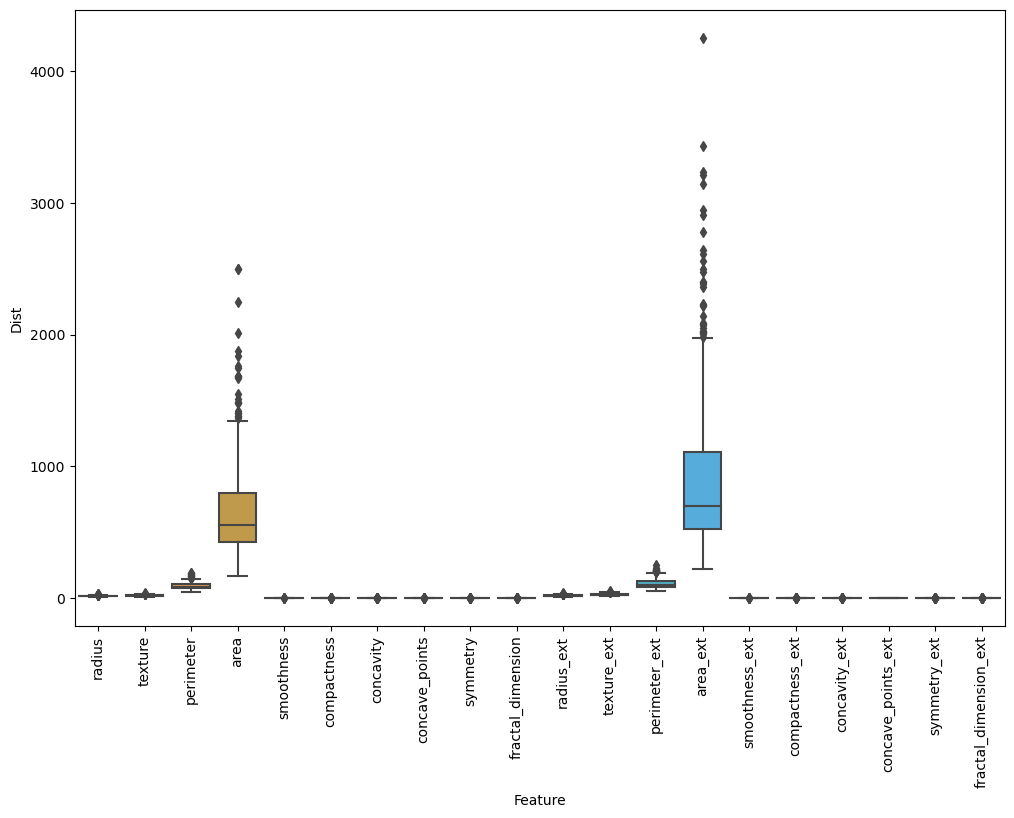

In [9]:
# Boxplot each feature - comparing mean, stde, ext
# Reworking, need to reset index for boxplot
mean_ext_cols = ['ID','radius','texture','perimeter','area','smoothness','compactness','concavity','concave_points','symmetry','fractal_dimension','radius_ext','texture_ext','perimeter_ext','area_ext','smoothness_ext','compactness_ext','concavity_ext','concave_points_ext','symmetry_ext','fractal_dimension_ext']
df_melt = pd.melt(df,id_vars='ID',var_name='Mean, Extreme',value_vars=mean_ext_cols)
plt.subplots(figsize=(12, 8))
sns.boxplot(x='Mean, Extreme', y='value', data=df_melt)
plt.xticks(rotation='vertical')
plt.ylabel('Dist')
plt.xlabel('Feature');


Majority of features show little variation. Only area (and perimeter but much less) has extreme outliers even for the 'mean' measurements.

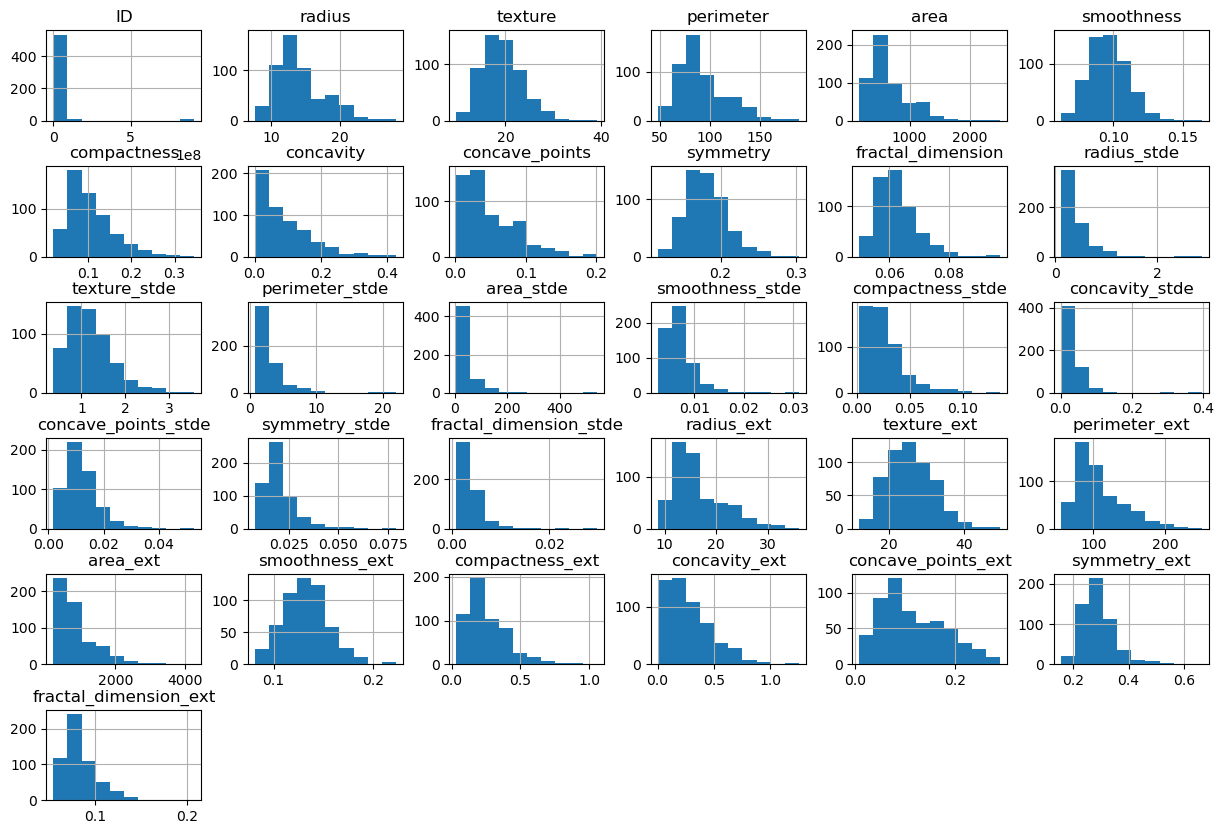

In [10]:
df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=.5);

Similar distributions between mean and extreme values of each feature. All plausible, no obvious outliers. Key features might be found in either group. Standard error is left skewed for all features so will drop.
(Preserving df as original dataframe minus null, setting df_2 as now working with only 2 sections.)

In [167]:
df_2 = df.drop(columns=['radius_stde', 'texture_stde', 'perimeter_stde',
       'area_stde', 'smoothness_stde', 'compactness_stde', 'concavity_stde',
       'concave_points_stde', 'symmetry_stde', 'fractal_dimension_stde'])
df_2.columns

Index(['ID', 'Diagnosis', 'radius', 'texture', 'perimeter', 'area',
       'smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry',
       'fractal_dimension', 'radius_ext', 'texture_ext', 'perimeter_ext',
       'area_ext', 'smoothness_ext', 'compactness_ext', 'concavity_ext',
       'concave_points_ext', 'symmetry_ext', 'fractal_dimension_ext'],
      dtype='object')

In [168]:
# Setting ID as index for df_2 (can return to df if needed)
df_2.set_index('ID',inplace=True)
df_2.head()

,Diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,symmetry,...,radius_ext,texture_ext,perimeter_ext,area_ext,smoothness_ext,compactness_ext,concavity_ext,concave_points_ext,symmetry_ext,fractal_dimension_ext
ID,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [169]:
# Statistical summary
df_2.describe().T

,count,mean,std,min,25%,50%,75%,max
radius,556.0,14.237565,3.482170,7.691000,11.760000,13.455000,16.040000,28.11000
texture,556.0,19.259748,4.246993,9.710000,16.177500,18.855000,21.735000,39.28000
perimeter,556.0,92.736673,24.006362,48.340000,75.845000,87.090000,105.250000,188.50000
area,556.0,663.734712,350.893313,170.400000,427.750000,557.650000,798.050000,2501.00000
smoothness,556.0,0.096616,0.013895,0.062510,0.086665,0.096035,0.105400,0.16340
compactness,556.0,0.105679,0.052643,0.019380,0.066608,0.095090,0.130600,0.34540
concavity,556.0,0.090876,0.079468,0.000692,0.030880,0.064905,0.132325,0.42680
concave_points,556.0,0.050063,0.038517,0.001852,0.020895,0.034840,0.074842,0.20120
symmetry,556.0,0.181278,0.027446,0.116700,0.161900,0.179250,0.195750,0.30400
fractal_dimension,556.0,0.062746,0.007059,0.049960,0.057675,0.061515,0.066090,0.09744


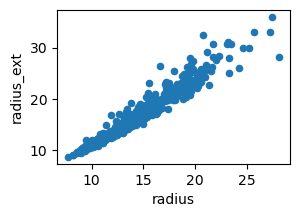

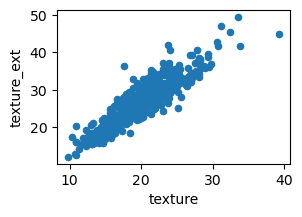

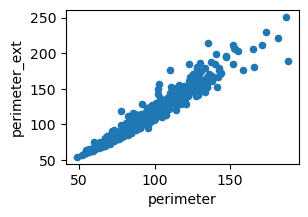

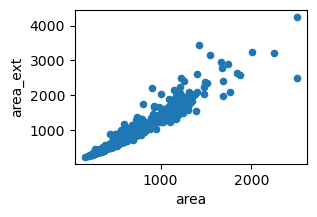

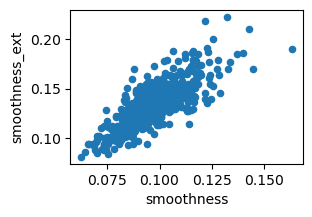

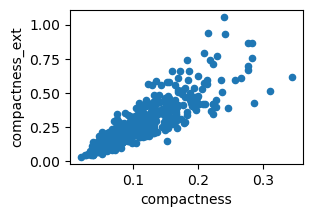

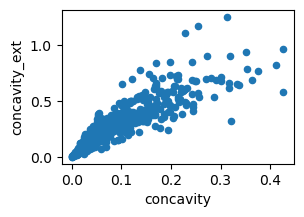

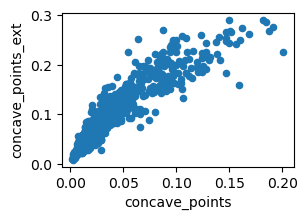

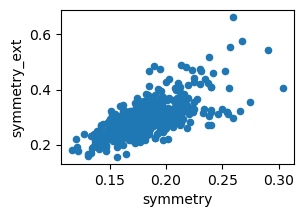

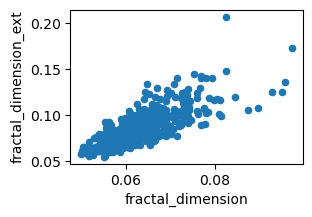

In [170]:
for feature in df_2.columns[1:11]:
    x_feat = str(feature)
    y_feat = str(feature + '_ext')
    df_2.plot(x=x_feat,y=y_feat,kind='scatter',figsize=(3,2));

Strong collinearity for radius and perimeter so will drop either mean or extreme. As mean and max of both radius_ext and perimeter_ext are greater than the 'mean' of each feature, we will keep those as the larger values are 'worse' and therefore more likely to indicate (or contraindicate) malignancy.
df_3 will drop 'radius' and 'perimeter' columns.

In [183]:
df_3 = df_2.drop(columns=['radius','perimeter'])

In [184]:
# Saving cleaned data in separate file
cwd = os.getcwd()
path = cwd + "/cleaned_data"
df_3.to_csv(path)

PCA - unsure if this would work here?

In [ ]:
#df_3.drop(columns='Diagnosis').head()

In [187]:
# Scaling
df_4 = df_3.reset_index(drop=True)
df_4 = df_4.set_index('Diagnosis')
diag_index = df_4.index # Saving index for later
df_4_scaled_array = scale(df_4)
df_4_scaled = pd.DataFrame(df_4_scaled_array,columns=df_4.columns)
df_4_scaled.head()

,texture,area,smoothness,compactness,concavity,concave_points,symmetry,fractal_dimension,radius_ext,texture_ext,perimeter_ext,area_ext,smoothness_ext,compactness_ext,concavity_ext,concave_points_ext,symmetry_ext,fractal_dimension_ext
0,-2.092715,0.962027,1.569101,3.268763,2.635200,2.521596,2.210800,2.263479,1.871814,-1.368696,2.292521,1.978253,1.300038,2.601101,2.097343,2.313236,2.731889,1.918937
1,-0.351093,1.889069,-0.855483,-0.514093,-0.050073,0.522500,-0.002847,-0.861584,1.790452,-0.372016,1.517911,1.867529,-0.399386,-0.459180,-0.178846,1.073172,-0.254987,0.269349
2,0.469048,1.538219,0.935223,1.030916,1.341684,2.022666,0.934398,-0.390839,1.494210,-0.024489,1.328761,1.433419,0.512284,1.060739,0.831718,1.963394,1.137598,0.189851
3,0.264013,-0.791935,3.305062,3.388546,1.895868,1.432786,2.859942,4.919216,-0.312449,0.134521,-0.281408,-0.572449,3.406616,3.883352,1.976346,2.189854,6.018905,4.905640
4,-1.159451,1.806348,0.265329,0.515659,1.349242,1.409399,-0.013787,-0.555317,1.279330,-1.476888,1.319754,1.197910,0.202494,-0.341624,0.587789,0.706151,-0.877858,-0.406386


In [188]:
df_4_scaled.agg(func=['mean','std'],axis=0).T
# Check scaling - means are all ~0 but std is off (calculated against sample mean so denom has to be constrained by 1)

,mean,std
texture,-1.916932e-16,1.0009
area,1.022364e-16,1.0009
smoothness,3.450477e-16,1.0009
compactness,-5.111818e-17,1.0009
concavity,7.667727e-17,1.0009
concave_points,-3.833864e-17,1.0009
symmetry,6.261977e-16,1.0009
fractal_dimension,1.153354e-15,1.0009
radius_ext,2.555909e-17,1.0009
texture_ext,-1.597443e-16,1.0009


In [19]:
df_4_scaled.std(ddof=0) # Scaling is accurate when constrained to sample - 1

texture                  1.0
area                     1.0
smoothness               1.0
compactness              1.0
concavity                1.0
concave_points           1.0
symmetry                 1.0
fractal_dimension        1.0
radius_ext               1.0
texture_ext              1.0
perimeter_ext            1.0
area_ext                 1.0
smoothness_ext           1.0
compactness_ext          1.0
concavity_ext            1.0
concave_points_ext       1.0
symmetry_ext             1.0
fractal_dimension_ext    1.0
dtype: float64

In [189]:
df_pca = PCA().fit(df_4_scaled) # Returns sklearn PCA object

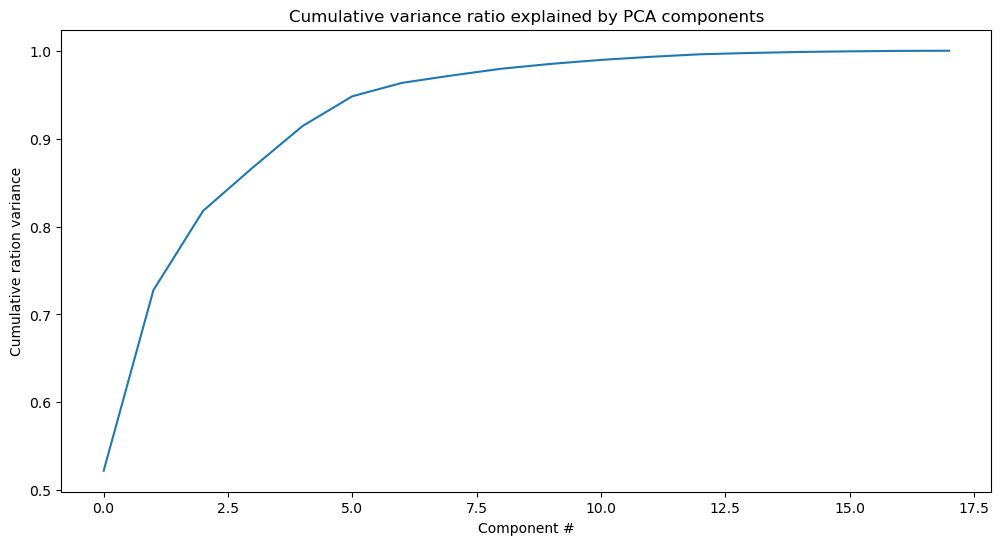

In [190]:
# Visualization of explained variance
plt.subplots(figsize=(12, 6))
plt.plot(df_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ration variance')
plt.title('Cumulative variance ratio explained by PCA components');
# Restrict x to int? Float is fine, can estimate visually

First 6 components account for ~95% of variance.

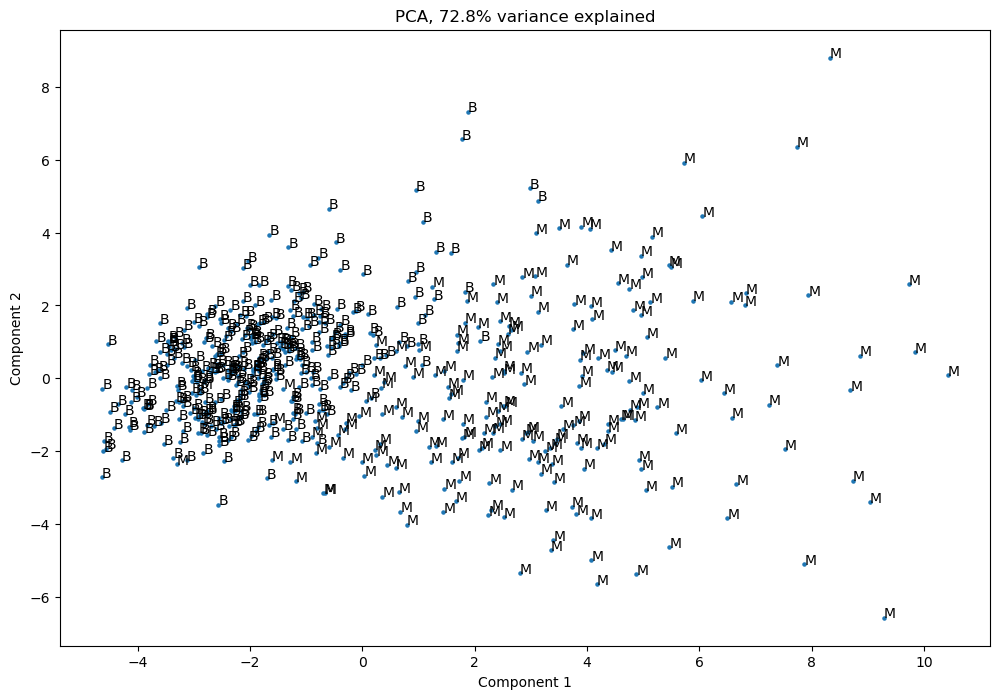

In [199]:
# Is scaling necessary here? Would we consider this data heterogeneous?
df_pca_x = df_pca.transform(df_4_scaled)

x = df_pca_x[:, 0]
y = df_pca_x[:, 1]

pc_var = 100 * df_pca.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(12,8))
plt.scatter(x=x, y=y, s=5)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title(f'PCA, {pc_var:.1f}% variance explained');
for s, x, y in zip(diag_index, x, y):
    plt.annotate(s, (x, y))
# How to change color of M/B points rather than annotate?
# Erase output to save space

In [211]:
# New dataframe to work with first 6 components
pca_df = pd.DataFrame({'PC1': df_pca_x[:,0],'PC2': df_pca_x[:,1],'PC3': df_pca_x[:,2],'PC4': df_pca_x[:,3],
                       'PC5': df_pca_x[:,4],'PC6': df_pca_x[:,5]}, index=diag_index)
pca_df.head(8)

,PC1,PC2,PC3,PC4,PC5,PC6
Diagnosis,,,,,,
M,7.939039,2.278253,-3.529872,0.022736,1.690487,-0.134818
M,1.457419,-3.033167,-1.257480,-0.062656,0.474234,-0.605134
M,4.604282,-1.123564,-0.935026,-0.709173,0.167962,-0.033717
M,8.327579,8.802946,0.565529,-1.136966,1.365143,-1.056008
M,2.071279,-1.980322,-2.913864,0.616509,-0.371968,0.247336
M,3.500316,4.129030,-0.728491,0.000395,-0.274213,-0.936321
M,2.129657,-1.912721,-0.340403,-0.278038,-0.076167,-0.838229
M,2.331259,2.585438,0.294455,-0.435857,-0.964745,0.195856


In [196]:
# Checking for null, expecting none
pca_df[pca_df.isnull().any(axis=1)]

,PC1,PC2,PC3,PC4,PC5,PC6
Diagnosis,,,,,,


In [224]:
pca_df.dtypes

Diagnosis     object
PC1          float64
PC2          float64
PC3          float64
PC4          float64
PC5          float64
PC6          float64
dtype: object

In [227]:
# Evaluating PCA components with feature labels (0 indexed)
pd.DataFrame(df_pca.components_, columns=df_4.columns).head(6)

,texture,area,smoothness,compactness,concavity,concave_points,symmetry,fractal_dimension,radius_ext,texture_ext,perimeter_ext,area_ext,smoothness_ext,compactness_ext,concavity_ext,concave_points_ext,symmetry_ext,fractal_dimension_ext
0,0.132991,0.232247,0.193003,0.293518,0.300430,0.302058,0.183305,0.106844,0.251265,0.145644,0.262831,0.244367,0.194361,0.276719,0.287517,0.308275,0.186186,0.196473
1,-0.150212,-0.336908,0.253033,0.138737,-0.003934,-0.096916,0.222645,0.434179,-0.311796,-0.107700,-0.290571,-0.313266,0.250866,0.151338,0.070489,-0.045341,0.198038,0.331213
2,0.634506,-0.150482,-0.185423,-0.065693,-0.080191,-0.153530,-0.073516,-0.006670,-0.099448,0.655213,-0.095950,-0.109836,0.006096,0.105034,0.063345,-0.051208,0.072232,0.131237
3,-0.056888,-0.013012,-0.203754,0.140447,0.165874,0.008355,-0.574700,0.218941,-0.048536,-0.106648,-0.022565,-0.040234,-0.153089,0.222992,0.250423,0.051730,-0.529547,0.307779
4,-0.156037,-0.027989,-0.563493,0.016772,0.035143,-0.105127,0.216354,-0.092466,-0.010211,-0.146962,0.012044,-0.041658,-0.492802,0.248404,0.217457,0.029061,0.440777,0.137328
5,0.267436,0.049744,0.040496,0.257040,0.284069,0.191061,0.424545,0.311632,-0.102461,-0.012632,-0.072798,-0.072290,-0.490038,-0.191956,-0.106967,-0.150607,-0.310243,-0.187613


In [ ]:
pd.DataFrame(df_pca.components_, columns=df_4.columns).max(axis=1)

In [ ]:
pd.DataFrame(df_pca.components_, columns=df_4.columns).min(axis=1)

In [ ]:
# DNR - this is a mess
# Would like to see top 3 scores/features for each PCA component
df_pcacomps = pd.DataFrame(df_pca.components_, columns=df_4.columns)
colmax1 = []
colmax2 = []
colmax3 = []
feat1name = []
feat2name = []
feat3name = []
for comp in df_pcacomps.index:
    max1 = df_pcacomps.loc[comp].max()
    feat1 = df_pcacomps.columns[(df_pcacomps == max1).any(axis=1)]
    colmax1.append(max1)
    feat1name.append(feat1.format())
    if comp == 0:
        colmax2.append(None)
        colmax3.append(None)
        feat2name.append(None)
        feat3name.append(None)
    else:
        max2 = df_pcacomps.loc[comp-1].max()
        feat2 = df_pcacomps.columns[(df_pcacomps == max2).any(axis=1)]
        colmax2.append(max2)
        feat2name.append(feat2.format())
        if comp > 1:
            max3 = df_pcacomps.loc[comp-2].max()
            feat3 = df_pcacomps.columns[(df_pcacomps == max3).any(axis=1)] 
            colmax3.append(max3)
            feat3name.append(feat3.format())
        else:
            colmax3.append(None)
            feat3name.append(None)
    
max_pca = pd.DataFrame(list(zip(feat1name,colmax1,feat2name,colmax2,feat3name,colmax3)),index=diag_index,
                       columns=['Feature1','Score1','Feature2','Score2','Feature3','Score3'])
max_pca

In [228]:
df_pcacomps = pd.DataFrame(df_pca.components_, columns=df_4.columns)
pca_freq = []
for i in df_pcacomps.index:
    pca_freq.append(df_pcacomps.loc[i].sort_values(ascending=False).index[0].format())
    pca_freq.append(df_pcacomps.loc[i].sort_values(ascending=False).index[1].format())
    pca_freq.append(df_pcacomps.loc[i].sort_values(ascending=False).index[2].format())
    
Counter(pca_freq).most_common()

[('concavity', 7),
 ('fractal_dimension', 6),
 ('concave_points_ext', 5),
 ('fractal_dimension_ext', 5),
 ('compactness_ext', 5),
 ('concave_points', 4),
 ('concavity_ext', 4),
 ('area_ext', 3),
 ('texture_ext', 2),
 ('symmetry_ext', 2),
 ('smoothness_ext', 2),
 ('compactness', 2),
 ('area', 2),
 ('perimeter_ext', 2),
 ('smoothness', 1),
 ('texture', 1),
 ('symmetry', 1)]

Unsure for now whether PCA was useful or not. Moving on.

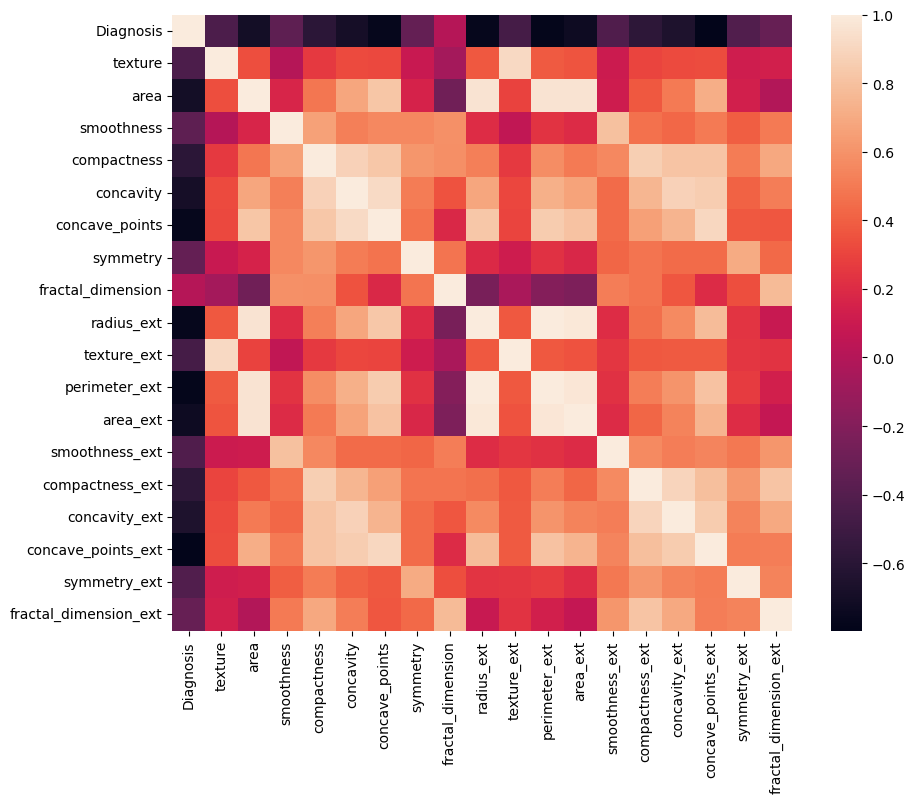

In [239]:
df_3_bool = df_3.copy()
df_3_bool['Diagnosis'] = df_3_bool['Diagnosis'].map({'M': 0, 'B': 1})
plt.subplots(figsize=(10,8))
sns.heatmap(df_3_bool.corr(numeric_only=True));

High correlations:
-texture, texture_ext - may drop one
-area, radius_ext, perimeter_ext, area_ext - makes sense, may drop
-*compactness, concavity, and concave points show decent correlation between mean/ext values - may drop*
Ultimately diagnosis seems correlated (only?) with texture, smoothness, symmetry, *fractal_dimension*, texture_ext, smoothness_ext, symmetry_ext, and fractal_dimension_ext.
May be worthwhile to also attempt/compare a model on only these features?

In [229]:
df_3.head()

,Diagnosis,texture,area,smoothness,compactness,concavity,concave_points,symmetry,fractal_dimension,radius_ext,texture_ext,perimeter_ext,area_ext,smoothness_ext,compactness_ext,concavity_ext,concave_points_ext,symmetry_ext,fractal_dimension_ext
ID,,,,,,,,,,,,,,,,,,,
842302,M,10.38,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,17.77,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,21.25,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,20.38,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,14.34,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


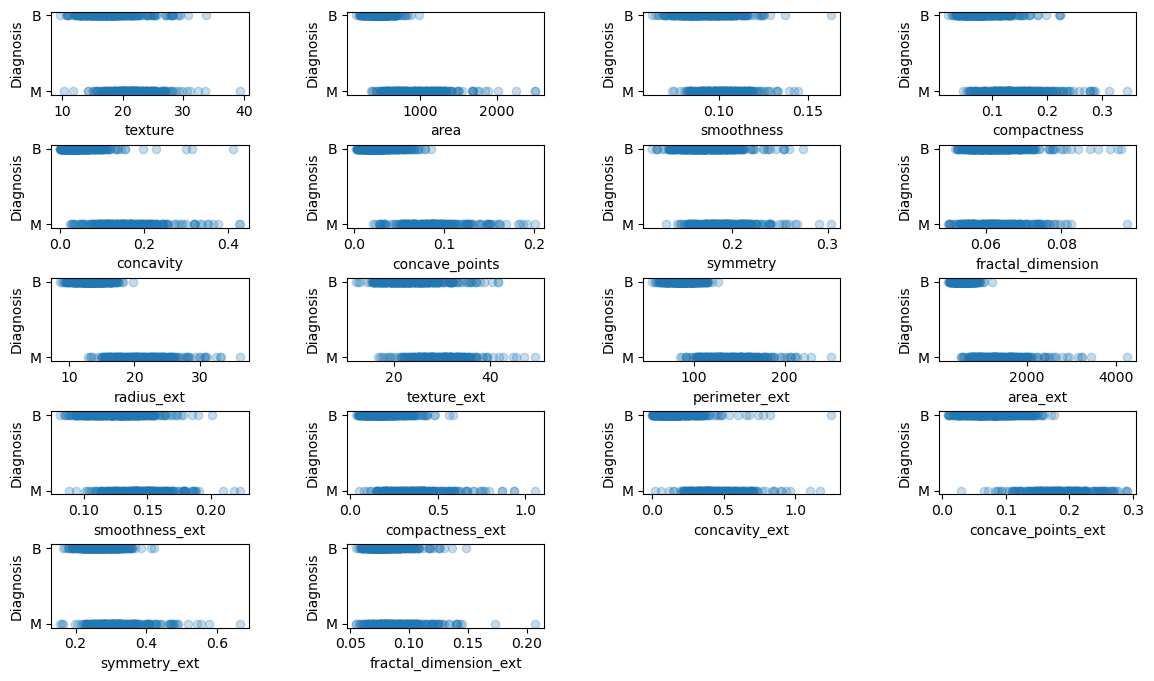

In [243]:
# Used 'scatterplots' function created in Guided Capstone with a few changes
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'Diagnosis', data=df_3, alpha=0.5)
        ax.set(xlabel=col, ylabel='Diagnosis')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
        
features = [x for x in df_3.columns if x not in ['Diagnosis']]
scatterplots(features, ncol=4, figsize=(14,8))

Confirms heatmap correlations (texture, texture_ext) although area and area_ext don't seem as highly correlated as I thought (esp for B cases) so will definitely have to look at both. Concavity and concavity_ext also seem to correlate strongly.
Texture, smoothness, compactness, symmetry, fractal_dimension, texture_ext, and smoothness_ext show large ranges for both B and M cases, which is interesting. The correlation may not be as obvious as some of the other features?

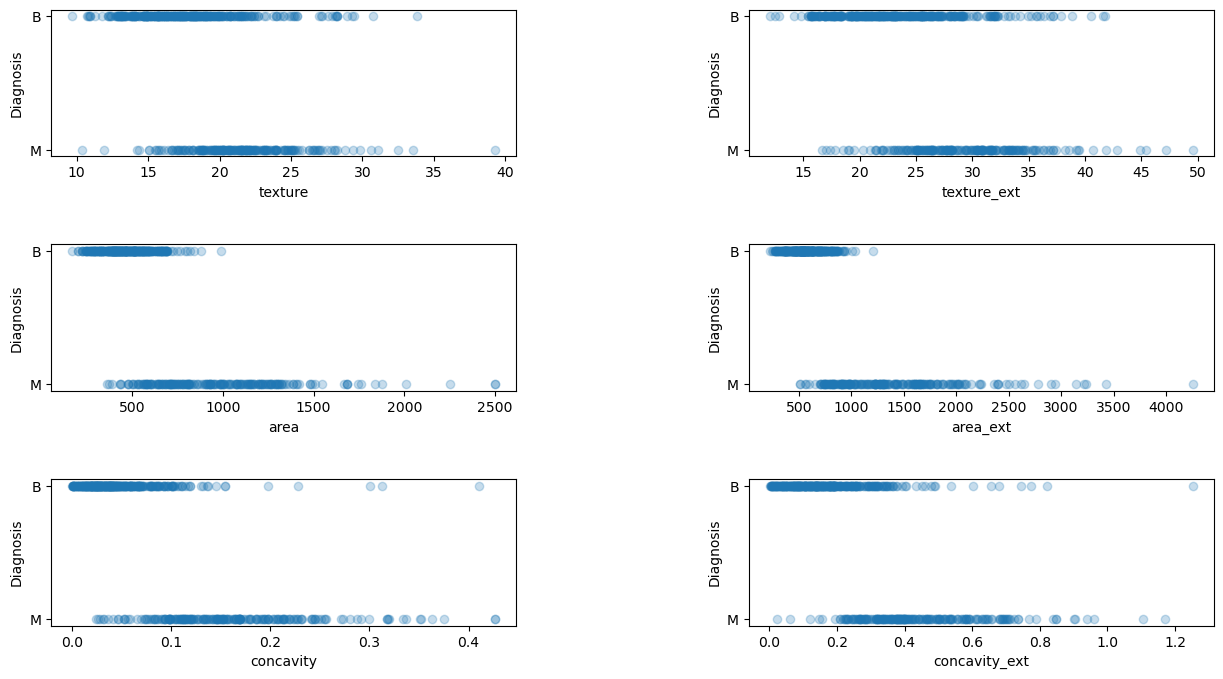

In [244]:
# Closer look at above listed features
scatterplots(['texture','texture_ext','area','area_ext','concavity','concavity_ext'],ncol=2)

Texture seems more useful than texture_ext.
Area_ext seems more useful than area.
Concavity seems more useful than concavity_ext.
Dropping the less useful in all cases.

In [246]:
df_working = df_3.drop(['texture_ext','area','concavity_ext'],axis=1)

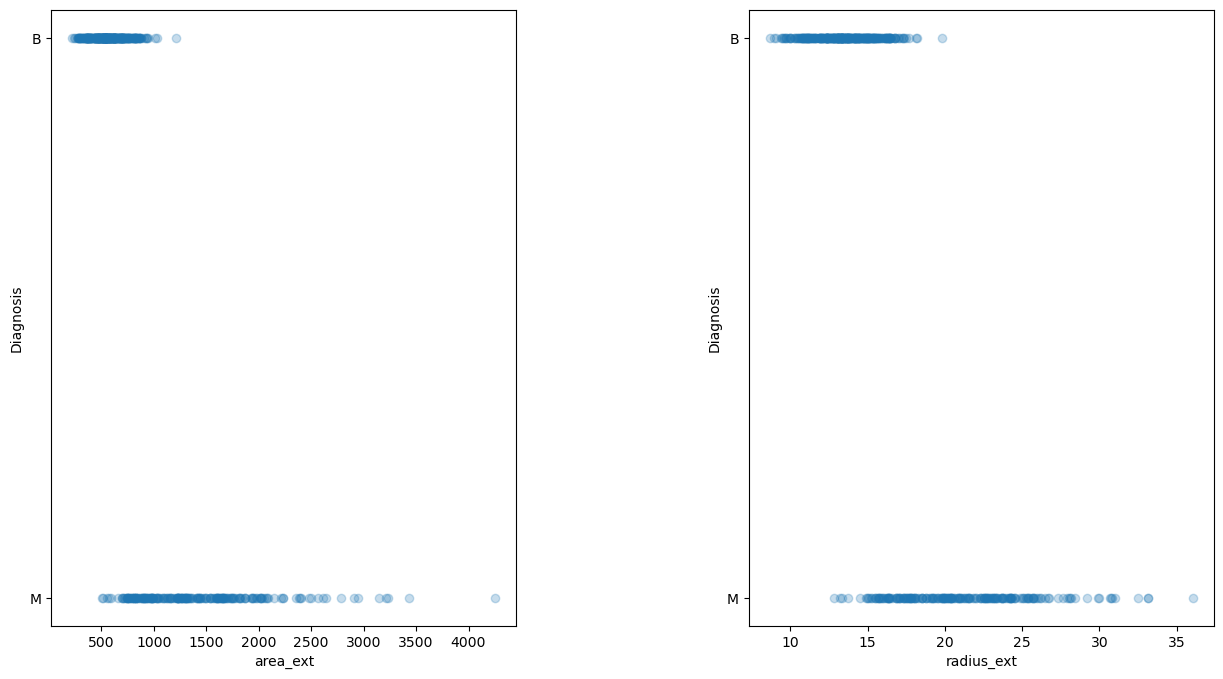

In [248]:
# Now comparing area_ext against radius_ext and perimeter_ext
scatterplots(['area_ext','radius_ext'],ncol=2)

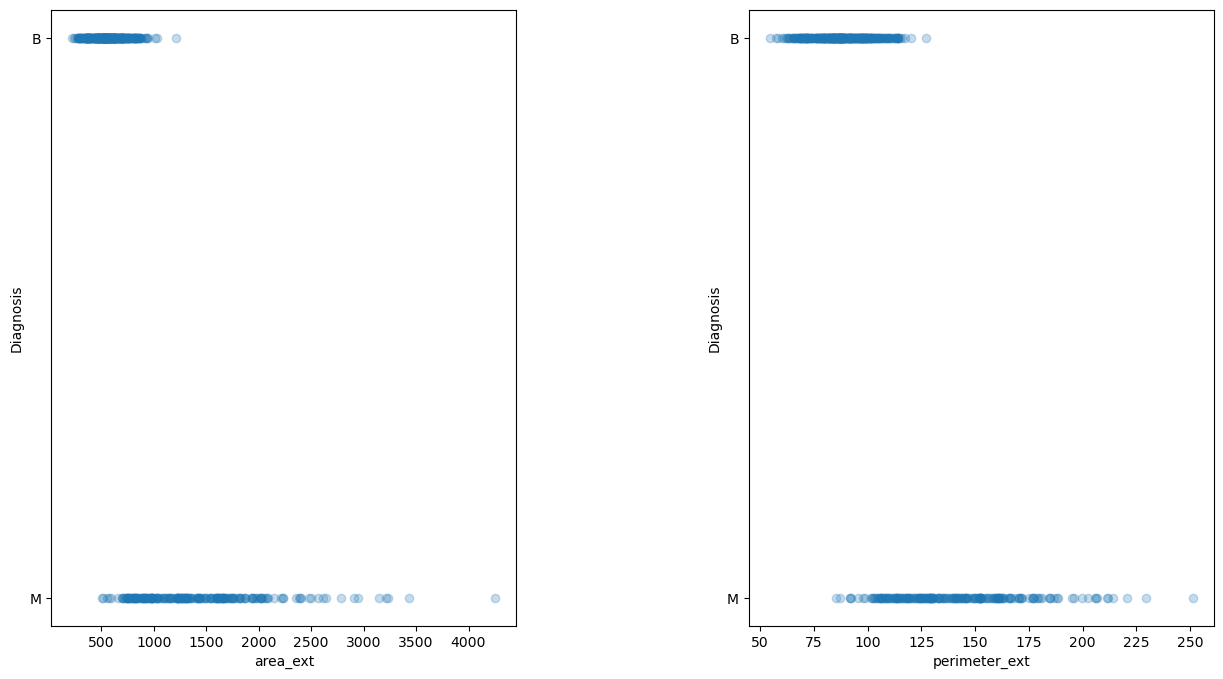

In [249]:
scatterplots(['area_ext','perimeter_ext'],ncol=2)

Correlation with area_ext not strong enough to drop either. Radius/perimeter_ext seem correlated but not clear which one would be more useful. Ending EDA here, reworked data is currently under df_working.
Summary:
Cut a few features that were very highly correlated with another (observed in heatmap and verified by plotting). A few other features seemed to also be somewhat highly correlated between mean/ext but not closely enough to merit dropping now. May impact modeling. (compactness and concave_points mean/ext, also radius and perimeter extremes)

# Preprocessing and Training

In [256]:
df_working.shape # Null value samples removed, working with 1/2 of original features (10x std)

(556, 16)

In [257]:
# Going right into train/test split
x_train, x_test, y_train, y_test = train_test_split(df_working.drop(columns='Diagnosis'), 
                                                    df_working.Diagnosis, test_size=0.3, 
                                                    random_state=47)

In [261]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape) # Correct

(389, 15) (167, 15) (389,) (167,)


In [ ]:
x_train.dtypes, x_test.dtypes # Correct, erased output

Since target feature (diagnosis) is essentially true/false, will try first a multivariate regression with just the 2 possible real values (0,1 if converted to boolean). Then that would just be ans<0.5, ans>0.5? Check online...